In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
import os
%matplotlib inline

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def mergeData():
    SaveFile_Name = 'data.csv'
    file_list = os.listdir('data')
    df = pd.read_csv('data'+'\\'+file_list[0])
    df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False)
    for i in range(1,len(file_list)):
        df = pd.read_csv('data'+'\\'+file_list[i])
        df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False, header=False, mode='a+')

In [3]:
def readData():
    train = pd.read_csv("data.csv")
    return train

In [4]:
def changeYear(data):
    for i in range(0,data.shape[0]):
        Date=data["日期"][i].split('/')
        year,month,date=Date[0],Date[1],Date[2]
        year=str(int(year)+1911)
        data.loc[i,"日期"]=year+'/'+month+'/'+date
    return data

In [5]:
# Augment Features
def augFeatures(data):
  data["日期"] = pd.to_datetime(data["日期"])
  data["年"] = data["日期"].dt.year
  data["月"] = data["日期"].dt.month
  data["日"] = data["日期"].dt.day
  data["第幾日"] = data["日期"].dt.dayofweek
  return data

In [6]:
def manage(data):
    for i in range(0,data.shape[0]):
        if data["漲跌價差"][i]=='X0.00':
            data.loc[i,"漲跌價差"]=str(int(data["收盤價"][i])-int(data["收盤價"][i-1]))
    data=data.drop(["日期"], axis=1)
    data=data.drop(["成交股數"], axis=1)
    data=data.drop(["成交金額"], axis=1)
    data=data.drop(["漲跌價差"], axis=1)
    data=data.drop(["成交筆數"], axis=1)
    data=data.convert_objects(convert_numeric=True)
    return data

In [7]:
from sklearn import preprocessing
def normalize(train):
    train = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train

In [8]:
def buildTrain(train, pastDay=30, futureDay=1):
    X_train, Y_train, Z_train= [], [], []
    X,Y,Z=[],[],[]
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["開盤價"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay]["開盤價"]))
    X=np.array(X_train)
    Y=np.array(Y_train)
    Z=np.array(Z_train)
    Y=100*((Y-Z)/Z)
    Y_train=[]
    
    for i in range(len(Y)):
        if Y[i]<-3.5:
            Y_train.append(np.array([0]))
        elif -3.5<=Y[i]<-2.5:
            Y_train.append(np.array([1]))
        elif -2.5<=Y[i]<-1.5:
            Y_train.append(np.array([2]))
        elif -1.5<=Y[i]<-0.5:
            Y_train.append(np.array([3]))
        elif -0.5<=Y[i]<0.5:
            Y_train.append(np.array([4]))
        elif 0.5<=Y[i]<1.5:
            Y_train.append(np.array([5]))
        elif 1.5<=Y[i]<2.5:
            Y_train.append(np.array([6]))
        elif 2.5<=Y[i]<3.5:
            Y_train.append(np.array([7]))
        elif 3.5<=Y[i]:
            Y_train.append(np.array([8]))
    Y=np.array(Y_train)
    
    return X, Y

In [9]:
def shuffle1(X,Y):
  np.random.seed()
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

In [10]:
# 將Training Data取一部份當作Validation Data
def splitData(X,Y,rate):
    X_train = X[:-int(X.shape[0]*rate)]

    Y_train = Y[:-int(Y.shape[0]*rate)]
    
    X_val = X[-int(X.shape[0]*rate):]

    Y_val = Y[-int(Y.shape[0]*rate):]
    return X_train, Y_train, X_val, Y_val

In [16]:
def buildModel(shape):
    model = Sequential()
    model.add(Dense(250, input_dim=shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(250))
    model.add(Activation('relu'))
    model.add(Dense(9))
    model.add(Activation('softmax'))
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [17]:
import matplotlib.pyplot as plt
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
 
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()


In [18]:
from sklearn.utils import shuffle

mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle1(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = LossHistory()
model = buildModel(train_x.shape)
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[history])



C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 250)               2250      
_________________________________________________________________
activation_4 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               62750     
_________________________________________________________________
activation_5 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 2259      
_________________________________________________________________
activation_6 (Activation)    (None, 9)                 0         
Total params: 67,259
Trainable params: 67,259
Non-trainable params: 0
_________________________________________________________________
Train 

Epoch 84/300
 - 0s - loss: 1.6316 - acc: 0.3800 - val_loss: 1.8021 - val_acc: 0.2849
Epoch 85/300
 - 0s - loss: 1.6279 - acc: 0.3746 - val_loss: 1.8169 - val_acc: 0.2814
Epoch 86/300
 - 0s - loss: 1.6234 - acc: 0.3792 - val_loss: 1.7890 - val_acc: 0.3065
Epoch 87/300
 - 0s - loss: 1.6186 - acc: 0.3814 - val_loss: 1.7838 - val_acc: 0.3082
Epoch 88/300
 - 0s - loss: 1.6104 - acc: 0.3788 - val_loss: 1.7947 - val_acc: 0.2903
Epoch 89/300
 - 0s - loss: 1.6033 - acc: 0.3804 - val_loss: 1.7906 - val_acc: 0.3047
Epoch 90/300
 - 0s - loss: 1.5964 - acc: 0.3814 - val_loss: 1.7772 - val_acc: 0.2975
Epoch 91/300
 - 0s - loss: 1.5880 - acc: 0.3890 - val_loss: 1.7904 - val_acc: 0.3029
Epoch 92/300
 - 0s - loss: 1.5808 - acc: 0.3974 - val_loss: 1.7820 - val_acc: 0.2993
Epoch 93/300
 - 0s - loss: 1.5849 - acc: 0.3900 - val_loss: 1.8167 - val_acc: 0.2796
Epoch 94/300
 - 0s - loss: 1.5800 - acc: 0.3956 - val_loss: 1.7679 - val_acc: 0.3029
Epoch 95/300
 - 0s - loss: 1.5684 - acc: 0.3990 - val_loss: 1.782

Epoch 180/300
 - 0s - loss: 1.3696 - acc: 0.4692 - val_loss: 1.8199 - val_acc: 0.3011
Epoch 181/300
 - 0s - loss: 1.3593 - acc: 0.4829 - val_loss: 1.7988 - val_acc: 0.3262
Epoch 182/300
 - 0s - loss: 1.3552 - acc: 0.4780 - val_loss: 1.8073 - val_acc: 0.3082
Epoch 183/300
 - 0s - loss: 1.3407 - acc: 0.4883 - val_loss: 1.7717 - val_acc: 0.3190
Epoch 184/300
 - 0s - loss: 1.3464 - acc: 0.4901 - val_loss: 1.7708 - val_acc: 0.3351
Epoch 185/300
 - 0s - loss: 1.3410 - acc: 0.4917 - val_loss: 1.7791 - val_acc: 0.3154
Epoch 186/300
 - 0s - loss: 1.3397 - acc: 0.4893 - val_loss: 1.7545 - val_acc: 0.3387
Epoch 187/300
 - 0s - loss: 1.3479 - acc: 0.4829 - val_loss: 1.7587 - val_acc: 0.3190
Epoch 188/300
 - 0s - loss: 1.3432 - acc: 0.4899 - val_loss: 1.7864 - val_acc: 0.3154
Epoch 189/300
 - 0s - loss: 1.3368 - acc: 0.4911 - val_loss: 1.7947 - val_acc: 0.3315
Epoch 190/300
 - 0s - loss: 1.3446 - acc: 0.4841 - val_loss: 1.8245 - val_acc: 0.3226
Epoch 191/300
 - 0s - loss: 1.3371 - acc: 0.4903 - val

Epoch 276/300
 - 0s - loss: 1.2297 - acc: 0.5326 - val_loss: 1.8705 - val_acc: 0.3029
Epoch 277/300
 - 0s - loss: 1.2558 - acc: 0.5151 - val_loss: 1.8881 - val_acc: 0.3280
Epoch 278/300
 - 0s - loss: 1.2330 - acc: 0.5378 - val_loss: 1.8274 - val_acc: 0.3280
Epoch 279/300
 - 0s - loss: 1.2386 - acc: 0.5340 - val_loss: 1.8580 - val_acc: 0.3118
Epoch 280/300
 - 0s - loss: 1.2386 - acc: 0.5236 - val_loss: 1.9064 - val_acc: 0.3029
Epoch 281/300
 - 0s - loss: 1.2347 - acc: 0.5364 - val_loss: 1.8943 - val_acc: 0.3100
Epoch 282/300
 - 0s - loss: 1.2285 - acc: 0.5362 - val_loss: 1.8397 - val_acc: 0.3118
Epoch 283/300
 - 0s - loss: 1.2374 - acc: 0.5304 - val_loss: 1.8570 - val_acc: 0.3190
Epoch 284/300
 - 0s - loss: 1.2277 - acc: 0.5348 - val_loss: 1.8377 - val_acc: 0.3262
Epoch 285/300
 - 0s - loss: 1.2152 - acc: 0.5416 - val_loss: 1.8577 - val_acc: 0.3226
Epoch 286/300
 - 0s - loss: 1.2289 - acc: 0.5292 - val_loss: 1.8503 - val_acc: 0.3369
Epoch 287/300
 - 0s - loss: 1.2284 - acc: 0.5316 - val

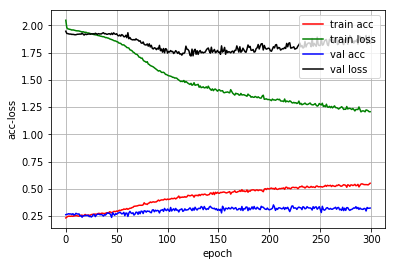

In [19]:
history.loss_plot('epoch')

In [20]:
loss, accuracy = model.evaluate(test_x, test_y)

print('test loss: ', loss)
print('test accuracy: ', accuracy)

618/618 [==============================] - 0s 19us/step
test loss:  1.8408504280843396
test accuracy:  0.3398058252909423
